In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

#%pdb

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def loadfile(mean, var, zmean, zvar, tau, temp, mixtures, model, data_size = "full",  scaling = False, model_save_dir = "", fn="", file = "res"):
    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model, mean, zmean, 50, tau, int(mixtures), int(temp), s, data_size) + fn
    if (file=='res'):
        with open(model_save_dir + '/mnist_retrain_res_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='gmp'):
        with open(model_save_dir + '/mnist_retrain_gmp_{}.p'.format(exp_name),'rb') as f:
            file = pickle.load(f)
    if (file=='model'):
        file = torch.load(model_save_dir + '/mnist_retrain_model_{}.m'.format(exp_name))
    return file

In [23]:
res = loadfile(250, 10, 2500, 1250, 1e-6, 5, 16, "LeNet_300_100", model_save_dir = "./files")

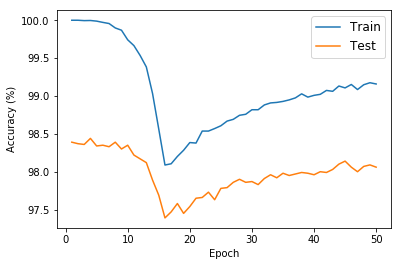

In [24]:
train = plt.plot(res['epochs'], res['train_acc'], label = "Train")
test = plt.plot(res['epochs'], res['test_acc'], label = "Test")
plt.legend(ncol=1, fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

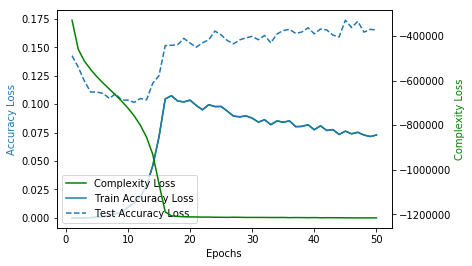

In [25]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Complexity Loss", color = 'g')
p = ax1.plot(res['epochs'], res['train_loss'][:-1], label = "Train Accuracy Loss")
color = p[0].get_color()
ax1.plot(res['epochs'], res['test_loss'], label = "Test Accuracy Loss", linestyle = "--", color = color)
ax1.legend(loc=3)
ax2.plot(res['epochs'], res['complexity_loss'], label = "Complexity", color = 'g')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy Loss', color=color)
ax2.set_ylabel('Complexity Loss', color='g')
plt.show()

In [27]:
print ('Prune Acc:{:.2f} Sparsity:{:.2f}'.format(res['prune_acc']['test'], res['sparsity']))

Prune Acc:97.59 Sparsity:97.45


### 3. Means

In [20]:
m_exp = pd.DataFrame(columns = ["mean", "zmean", "acc", "sp"])
idx=0
#start from 10, 1000
mlist = [0.1, 1, 10, 100, 1000]
zmlist = [10, 100, 1000, 5000]
for mean in mlist:
    for zmean in zmlist:
        res = loadfile(mean, 10, zmean, 1250, 1e-6, 5, 16, "LeNet_300_100", model_save_dir = "./files")
        m_exp.loc[idx] = ([mean, zmean, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

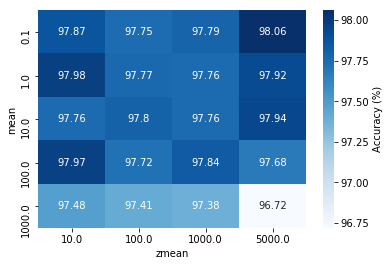

In [21]:
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt="g")

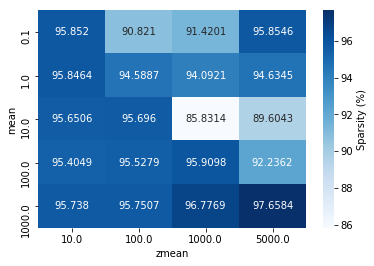

In [22]:
sns.heatmap(m_exp.pivot(index='mean', columns='zmean', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt="g")

### 4. Temp Tau Exp

In [8]:
tt_exp = pd.DataFrame(columns = ["temp", "tau", "acc", "sp"])
idx=0
#start from 10, 1000
temp_list = [1, 2, 4, 5, 6, 8]
tau_list = [5e-6, 2e-6, 1e-6, 5e-7, 2e-7, 1e-7]
for temp in temp_list:
    for tau in tau_list:
        res = loadfile(250, 10, 2500, 1250, tau, temp, 16, "LeNet_300_100", model_save_dir = "./files")
        tt_exp.loc[idx] = ([temp, tau, res["prune_acc"]["test"], res["sparsity"]])
        idx+=1

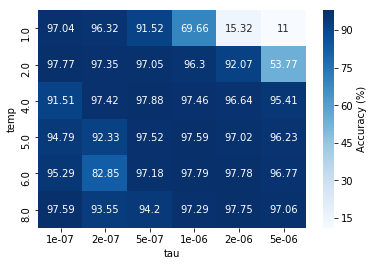

In [9]:
sns.heatmap(tt_exp.pivot(index='temp', columns='tau', values='acc'), cmap='Blues', cbar_kws = {'label' : 'Accuracy (%)'}, annot=True, fmt="g")

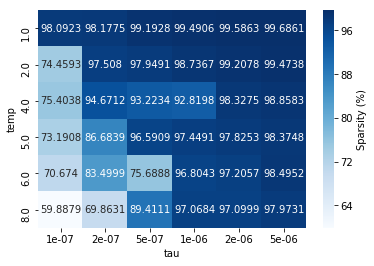

In [10]:
sns.heatmap(tt_exp.pivot(index='temp', columns='tau', values='sp'), cmap='Blues', cbar_kws = {'label' : 'Sparsity (%)'}, annot=True, fmt="g")

In [13]:
tt_exp.query("sp > 97.2 and acc > 97.2")

,temp,tau,acc,sp
10,2.0,2.000000e-07,97.35,97.507970
20,5.0,1.000000e-06,97.59,97.449083
25,6.0,2.000000e-06,97.78,97.205656
